In [1]:
%load_ext autoreload
%autoreload 2

# Fieldnames are used to store data
from gluonts.dataset.field_names import FieldName
import numpy as np s
import pandas as pd 
[f"FieldName.{k} = '{v}'" for k, v in FieldName.__dict__.items() if not k.startswith('_')]

["FieldName.ITEM_ID = 'item_id'",
 "FieldName.START = 'start'",
 "FieldName.TARGET = 'target'",
 "FieldName.FEAT_STATIC_CAT = 'feat_static_cat'",
 "FieldName.FEAT_STATIC_REAL = 'feat_static_real'",
 "FieldName.FEAT_DYNAMIC_CAT = 'feat_dynamic_cat'",
 "FieldName.FEAT_DYNAMIC_REAL = 'feat_dynamic_real'",
 "FieldName.FEAT_TIME = 'time_feat'",
 "FieldName.FEAT_CONST = 'feat_dynamic_const'",
 "FieldName.FEAT_AGE = 'feat_dynamic_age'",
 "FieldName.OBSERVED_VALUES = 'observed_values'",
 "FieldName.IS_PAD = 'is_pad'",
 "FieldName.FORECAST_START = 'forecast_start'"]

Fieldnames are one of three types: 
- required 
    - start 
    - target
- optional 
    - feat_static_cat: static (over time) categorical features, list with dimension equal to the number of features (duration)
    - feat_static_real:  static (over time) real features, list with dimension equal to the number of features (strike)
    - etc. 
Added by Transformation:
    - time_feat: time related features such as the month or the day

In [9]:
# Add folder location to Python paths so that packages can be imported 
import sys, os 

p = os.path.abspath('../')
if p not in sys.path:
    sys.path.append(p)
    
sys.path

['/Users/rekahalmai/PycharmProjects/implied_vol_copy/implied_vol_prediction/notebooks',
 '/Users/rekahalmai/PycharmProjects/implied_vol_copy/implied_vol_prediction',
 '/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.7/lib/python37.zip',
 '/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.7/lib/python3.7',
 '/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.7/lib/python3.7/lib-dynload',
 '',
 '/Users/rekahalmai/PycharmProjects/implied_vol_copy/implied_vol_prediction/venv/lib/python3.7/site-packages',
 '/Users/rekahalmai/PycharmProjects/implied_vol_copy/implied_vol_prediction/venv/lib/python3.7/site-packages/setuptools-40.8.0-py3.7.egg',
 '/Users/rekahalmai/PycharmProjects/implied_vol_copy/implied_vol_prediction/venv/lib/python3.7/site-packages/pip-19.0.3-py3.7.egg',
 '/Users/rekahalmai/PycharmProjects/implied_vol_copy/implied_vol_prediction/venv/lib/python3.7/site-packages/IPython/ext

In [10]:
def open_and_transform_csv2(file):
    df = pd.read_excel(file, header=[2, 3], parse_dates=True)
    cols = df.columns

    df_total = pd.DataFrame()

    if 'weekly' in str(file):
        dates_spots = pd.DataFrame(df[[('Unnamed: 0_level_0', 'Dates'), \
                                       ('Unnamed: 1_level_0', 'Spot t'), \
                                       ('Unnamed: 2_level_0', 'Spot t-5')]])
    else:
        dates_spots = pd.DataFrame(df[[('Unnamed: 0_level_0', 'Dates'), \
                                       ('Unnamed: 1_level_0', 'Spot t'), \
                                       ('Unnamed: 2_level_0', 'Spot t-1')]])

    dates_spots.columns = [f'{j}' for i, j in dates_spots.columns]

    for i in range(3, 47):
        duration, strike = cols[i]
        logger.info(f'Treating column duration: {duration}, strike: {strike}')
        df_one_col, df_one_col["Volatility"] = dates_spots, pd.DataFrame(df.iloc[:, i])
        df_one_col['Duration'], df_one_col['Strike'] = duration, strike

        if duration == "6M":
            df_one_col["Implied_vol"] = df.iloc[:, i + 45]
            df_one_col["Change_in_implied_vol"] = df.iloc[:, i + 54]
        elif duration == "1Y":
            df_one_col["Implied_vol"] = df.iloc[:, i + 54]
            df_one_col["Change_in_implied_vol"] = df.iloc[:, i + 63]
        elif duration == "18M":
            df_one_col["Implied_vol"] = df.iloc[:, i + 63]
            df_one_col["Change_in_implied_vol"] = df.iloc[:, i + 72]
        elif duration == "2Y":
            df_one_col["Implied_vol"] = df.iloc[:, i + 72]
            df_one_col["Change_in_implied_vol"] = df.iloc[:, i + 81]
        elif duration == "3Y":
            df_one_col["Implied_vol"] = df.iloc[:, i + 81]
            df_one_col["Change_in_implied_vol"] = df.iloc[:, i + 90]

        df_total = pd.concat([df_total, df_one_col])

    df_total = df_total.dropna()
    logger.info(df_total.isnull().sum())

    return df_total

# Gluonts example 

In [13]:
def create_dataset(num_series, num_steps, period=24, mu=1, sigma=0.3):
    # create target: noise + pattern
    # noise
    noise = np.random.normal(mu, sigma, size=(num_series, num_steps))

    # pattern - sinusoid with different phase
    sin_minumPi_Pi = np.sin(np.tile(np.linspace(-np.pi, np.pi, period), int(num_steps / period)))
    sin_Zero_2Pi = np.sin(np.tile(np.linspace(0, 2 * np.pi, 24), int(num_steps / period)))

    pattern = np.concatenate((np.tile(sin_minumPi_Pi.reshape(1, -1),
                                      (int(np.ceil(num_series / 2)),1)),
                              np.tile(sin_Zero_2Pi.reshape(1, -1),
                                      (int(np.floor(num_series / 2)), 1))
                             ),
                             axis=0
                            )

    target = noise + pattern

    # create time features: use target one period earlier, append with zeros
    feat_dynamic_real = np.concatenate((np.zeros((num_series, period)),
                                        target[:, :-period]
                                       ),
                                       axis=1
                                      )

    # create categorical static feats: use the sinusoid type as a categorical feature
    feat_static_cat = np.concatenate((np.zeros(int(np.ceil(num_series / 2))),
                                      np.ones(int(np.floor(num_series / 2)))
                                     ),
                                     axis=0
                                    )

    return target, feat_dynamic_real, feat_static_cat

In [27]:
# define the parameters of the dataset
custom_ds_metadata_ex = {'num_series': 100,
                      'num_steps': 24 * 7,
                      'prediction_length': 24,
                      'freq': '1H',
                      'start': [pd.Timestamp("01-01-2019", freq='1H')
                                for _ in range(100)]
                     }

In [28]:
data_out_example = create_dataset(custom_ds_metadata_ex['num_series'],
                          custom_ds_metadata_ex['num_steps'],
                          custom_ds_metadata_ex['prediction_length']
                         )

target_ex, feat_dynamic_real_ex, feat_static_cat_ex = data_out_example

In [72]:
target_ex.shape # 100 time series and 168 entries each 
target_ex[0], 24 * 7

(array([ 0.20542126,  0.7096111 ,  0.16864173, -0.07063843,  0.32283505,
         0.34453311, -0.39637134,  0.33999324, -0.07320672,  0.35048864,
         0.34647877,  0.73025229,  1.1850156 ,  1.58321245,  1.78452513,
         2.03943043,  2.08690526,  2.28139553,  1.89455002,  2.25352567,
         1.63752425,  1.6705042 ,  1.44312028,  1.01971316,  0.91390549,
         0.69884176,  0.11564777, -0.11324468,  0.55529787, -0.1098911 ,
         0.35987247,  0.10890566,  0.31138589,  0.8286673 ,  0.83821387,
         1.03605525,  1.47653058,  1.57834144,  1.4257284 ,  1.70941153,
         1.6496735 ,  1.96706251,  1.86221166,  1.92802466,  1.15318907,
         1.37259124,  1.40325279,  0.77243592,  1.29748192,  0.70334629,
         0.5948436 ,  0.46968543,  0.18654055, -0.11973884,  0.17566989,
        -0.59941892,  0.11420356,  0.63535673,  0.76753667,  1.09401737,
         0.93825489,  1.36311191,  1.64717991,  2.02486179,  1.94721561,
         2.39054432,  1.87246085,  1.72939799,  1.1

In [29]:
type(target_ex), type(feat_dynamic_real_ex), type(feat_static_cat_ex), 
target_ex.shape, feat_dynamic_real_ex.shape, feat_static_cat_ex.shape

((100, 168), (100, 168), (100,))

In [86]:
feat_static_cat_ex.shape

(100,)

In [87]:
from gluonts.dataset.common import ListDataset

train_ds = [{FieldName.TARGET: target,
                         FieldName.START: start,
                         FieldName.FEAT_DYNAMIC_REAL: fdr,
                         FieldName.FEAT_STATIC_CAT: fsc}
                        for (target, start, fdr, fsc) in zip(target_ex[:, :-custom_ds_metadata_ex['prediction_length']],
                                                             custom_ds_metadata_ex['start'],
                                                             feat_dynamic_real_ex[:, :-custom_ds_metadata_ex['prediction_length']],
                                                             feat_static_cat_ex)]

In [65]:
train_ds[0]

{'target': array([ 0.20542126,  0.7096111 ,  0.16864173, -0.07063843,  0.32283505,
         0.34453311, -0.39637134,  0.33999324, -0.07320672,  0.35048864,
         0.34647877,  0.73025229,  1.1850156 ,  1.58321245,  1.78452513,
         2.03943043,  2.08690526,  2.28139553,  1.89455002,  2.25352567,
         1.63752425,  1.6705042 ,  1.44312028,  1.01971316,  0.91390549,
         0.69884176,  0.11564777, -0.11324468,  0.55529787, -0.1098911 ,
         0.35987247,  0.10890566,  0.31138589,  0.8286673 ,  0.83821387,
         1.03605525,  1.47653058,  1.57834144,  1.4257284 ,  1.70941153,
         1.6496735 ,  1.96706251,  1.86221166,  1.92802466,  1.15318907,
         1.37259124,  1.40325279,  0.77243592,  1.29748192,  0.70334629,
         0.5948436 ,  0.46968543,  0.18654055, -0.11973884,  0.17566989,
        -0.59941892,  0.11420356,  0.63535673,  0.76753667,  1.09401737,
         0.93825489,  1.36311191,  1.64717991,  2.02486179,  1.94721561,
         2.39054432,  1.87246085,  1.7293

In [46]:
[{FieldName.TARGET: target, \
FieldName.START: start, \
FieldName.FEAT_DYNAMIC_REAL: fdr, \
FieldName.FEAT_STATIC_CAT: fsc} for (target, start, fdr, fsc) in zip(target_ex[:, :-custom_ds_metadata_ex['prediction_length']], \
                                                             custom_ds_metadata_ex['start'], \
                                                             feat_dynamic_real_ex[:, :-custom_ds_metadata_ex['prediction_length']], \
                                                             feat_static_cat_ex)]

[{'target': array([ 0.20542126,  0.7096111 ,  0.16864173, -0.07063843,  0.32283505,
          0.34453311, -0.39637134,  0.33999324, -0.07320672,  0.35048864,
          0.34647877,  0.73025229,  1.1850156 ,  1.58321245,  1.78452513,
          2.03943043,  2.08690526,  2.28139553,  1.89455002,  2.25352567,
          1.63752425,  1.6705042 ,  1.44312028,  1.01971316,  0.91390549,
          0.69884176,  0.11564777, -0.11324468,  0.55529787, -0.1098911 ,
          0.35987247,  0.10890566,  0.31138589,  0.8286673 ,  0.83821387,
          1.03605525,  1.47653058,  1.57834144,  1.4257284 ,  1.70941153,
          1.6496735 ,  1.96706251,  1.86221166,  1.92802466,  1.15318907,
          1.37259124,  1.40325279,  0.77243592,  1.29748192,  0.70334629,
          0.5948436 ,  0.46968543,  0.18654055, -0.11973884,  0.17566989,
         -0.59941892,  0.11420356,  0.63535673,  0.76753667,  1.09401737,
          0.93825489,  1.36311191,  1.64717991,  2.02486179,  1.94721561,
          2.39054432,  1.872

In [63]:
# List containing a dictionary
type(train_ds), len(train_ds)

(list, 100)

In [54]:
#type(train_ds[0]), 
train_ds[0]['target']

array([ 0.20542126,  0.7096111 ,  0.16864173, -0.07063843,  0.32283505,
        0.34453311, -0.39637134,  0.33999324, -0.07320672,  0.35048864,
        0.34647877,  0.73025229,  1.1850156 ,  1.58321245,  1.78452513,
        2.03943043,  2.08690526,  2.28139553,  1.89455002,  2.25352567,
        1.63752425,  1.6705042 ,  1.44312028,  1.01971316,  0.91390549,
        0.69884176,  0.11564777, -0.11324468,  0.55529787, -0.1098911 ,
        0.35987247,  0.10890566,  0.31138589,  0.8286673 ,  0.83821387,
        1.03605525,  1.47653058,  1.57834144,  1.4257284 ,  1.70941153,
        1.6496735 ,  1.96706251,  1.86221166,  1.92802466,  1.15318907,
        1.37259124,  1.40325279,  0.77243592,  1.29748192,  0.70334629,
        0.5948436 ,  0.46968543,  0.18654055, -0.11973884,  0.17566989,
       -0.59941892,  0.11420356,  0.63535673,  0.76753667,  1.09401737,
        0.93825489,  1.36311191,  1.64717991,  2.02486179,  1.94721561,
        2.39054432,  1.87246085,  1.72939799,  1.1461295 ,  1.18

In [42]:
for (target, start, fdr, fsc) in zip(target_ex[:, :-custom_ds_metadata_ex['prediction_length']],
                                                             custom_ds_metadata_ex['start'],
                                                             feat_dynamic_real_ex[:, :-custom_ds_metadata_ex['prediction_length']],
                                                             feat_static_cat_ex): 
    print([target], [start], fdr, fsc)

[array([ 0.20542126,  0.7096111 ,  0.16864173, -0.07063843,  0.32283505,
        0.34453311, -0.39637134,  0.33999324, -0.07320672,  0.35048864,
        0.34647877,  0.73025229,  1.1850156 ,  1.58321245,  1.78452513,
        2.03943043,  2.08690526,  2.28139553,  1.89455002,  2.25352567,
        1.63752425,  1.6705042 ,  1.44312028,  1.01971316,  0.91390549,
        0.69884176,  0.11564777, -0.11324468,  0.55529787, -0.1098911 ,
        0.35987247,  0.10890566,  0.31138589,  0.8286673 ,  0.83821387,
        1.03605525,  1.47653058,  1.57834144,  1.4257284 ,  1.70941153,
        1.6496735 ,  1.96706251,  1.86221166,  1.92802466,  1.15318907,
        1.37259124,  1.40325279,  0.77243592,  1.29748192,  0.70334629,
        0.5948436 ,  0.46968543,  0.18654055, -0.11973884,  0.17566989,
       -0.59941892,  0.11420356,  0.63535673,  0.76753667,  1.09401737,
        0.93825489,  1.36311191,  1.64717991,  2.02486179,  1.94721561,
        2.39054432,  1.87246085,  1.72939799,  1.1461295 ,  1.1

  2.04391809  1.70675895  1.78354856  1.60356432  1.1041739   0.82625374] 0.0
[array([ 8.65024519e-01,  9.28425883e-01,  3.65502168e-01,  1.96775050e-01,
       -7.39326406e-02, -8.12094149e-01,  4.05884310e-01,  3.63456537e-01,
       -4.05798920e-03, -5.33630943e-02,  7.08500142e-01,  1.28907826e+00,
        1.03666211e+00,  1.17170034e+00,  2.18985890e+00,  1.77817568e+00,
        1.88686213e+00,  2.58561034e+00,  2.03742387e+00,  2.20673979e+00,
        1.90872977e+00,  1.16015106e+00,  1.09751186e+00,  9.05998286e-01,
        1.58504085e+00,  7.51058379e-01,  7.97746532e-01,  1.44481560e-01,
        2.77873913e-01, -2.85465778e-01, -2.34318132e-01,  3.37936408e-01,
        3.30108882e-02,  3.92603350e-01,  4.69632131e-01,  1.02389471e+00,
        1.10834494e+00,  1.14496893e+00,  1.61644181e+00,  1.71612332e+00,
        1.64231625e+00,  2.02326611e+00,  1.85461613e+00,  1.38952492e+00,
        1.73882432e+00,  1.54327142e+00,  1.44911672e+00,  6.60548660e-01,
        8.39009130e-0

  0.01560297  0.49593379  0.96510092  0.64596133  0.81968241  1.03550926] 1.0
[array([ 1.02841701,  1.04479714,  1.3891343 ,  1.40982627,  1.91260859,
        2.51579616,  2.06387375,  1.67812329,  1.60809431,  1.40888913,
        1.68359194,  0.69580686,  0.86786497,  0.77835013,  0.5989585 ,
        0.22616211,  0.31211273, -0.2640827 ,  0.1849947 , -0.09665251,
        0.3078511 ,  0.52521686,  0.22605466,  0.66167248,  1.35950898,
        1.37812353,  1.49721374,  1.5861781 ,  2.19152927,  2.57390561,
        2.03478223,  2.01288035,  2.06889679,  1.96433672,  1.07246416,
        1.1676281 ,  0.96748901,  0.63281535,  0.95981322,  0.49716966,
       -0.08354068, -0.13371271, -0.16885845,  0.49677511,  0.24774939,
        0.28555081,  0.23584842,  1.42435501,  0.8432675 ,  1.16316036,
        1.34125725,  1.78905447,  1.64194065,  1.48469773,  1.55734208,
        1.6723888 ,  1.88262462,  1.73699253,  1.35853515,  0.84918456,
        1.18775717,  0.36304876,  0.73199042, -0.07876437

# My data 

In [73]:
import logging 
logger = logging.getLogger()

spx_daily = open_and_transform_csv2(r'../data/spx_daily.xlsx')

In [74]:
spx_daily.head()

,Dates,Spot t,Spot t-1,Volatility,Duration,Strike,Implied_vol,Change_in_implied_vol
0,2019-04-18,2900.45,2900.45,38.4404,6M,40,38.440400,1.641000
1,2019-04-17,2900.45,2907.06,36.7994,6M,40,36.775402,0.371102
2,2019-04-16,2907.06,2905.58,36.4043,6M,40,36.408560,0.770860
3,2019-04-15,2905.58,2907.41,35.6377,6M,40,35.632016,0.756616
4,2019-04-12,2907.41,2888.32,34.8754,6M,40,34.972001,-0.474299


In [130]:
custom_ds_metadata

{'num_series': 35,
 'num_steps': 3230,
 'prediction_length': 7,
 'freq': '1D',
 'start': [Timestamp('2006-12-01 00:00:00', freq='D'),
  Timestamp('2006-12-01 00:00:00', freq='D'),
  Timestamp('2006-12-01 00:00:00', freq='D'),
  Timestamp('2006-12-01 00:00:00', freq='D'),
  Timestamp('2006-12-01 00:00:00', freq='D'),
  Timestamp('2006-12-01 00:00:00', freq='D'),
  Timestamp('2006-12-01 00:00:00', freq='D'),
  Timestamp('2006-12-01 00:00:00', freq='D'),
  Timestamp('2006-12-01 00:00:00', freq='D'),
  Timestamp('2006-12-01 00:00:00', freq='D'),
  Timestamp('2006-12-01 00:00:00', freq='D'),
  Timestamp('2006-12-01 00:00:00', freq='D'),
  Timestamp('2006-12-01 00:00:00', freq='D'),
  Timestamp('2006-12-01 00:00:00', freq='D'),
  Timestamp('2006-12-01 00:00:00', freq='D'),
  Timestamp('2006-12-01 00:00:00', freq='D'),
  Timestamp('2006-12-01 00:00:00', freq='D'),
  Timestamp('2006-12-01 00:00:00', freq='D'),
  Timestamp('2006-12-01 00:00:00', freq='D'),
  Timestamp('2006-12-01 00:00:00', fre

In [75]:
strikes = [40,  60,  80,  90, 100, 110, 120]
maturities = ["6M", "1Y", "18M", "2Y", "3Y"]

# Start date
start = spx_daily.Dates.min()

target = []
nb_series = 0
feat_static_cat = []
feat_static_real = []

for s in strikes:
    for m in maturities: 
        df_temp = spx_daily[(spx_daily.Strike == s) & (spx_daily.Duration == m)].sort_values(by="Dates")
        target.append(df_temp.Change_in_implied_vol.values)
        nb_series += 1
        feat_static_real.append(s)
        feat_static_cat.append(m)
        
target, feat_static_real, feat_static_cat = np.array(target), np.array(feat_static_real), np.array(feat_static_cat)

In [76]:
type(target), type(feat_static_real), type(feat_static_cat)
target.shape, feat_static_real.shape, feat_static_cat.shape

((35, 3230), (35,), (35,))

In [80]:
target[0]

array([-0.01006993,  0.2887139 , -0.00359216, ...,  0.77085958,
        0.37110167,  1.641     ])

In [116]:
list_of_dicts = []
for ts in range(0, 35): 
    dict1 = {FieldName.TARGET: target[ts, :-custom_ds_metadata['prediction_length']], FieldName.START: start, FieldName.FEAT_STATIC_REAL: feat_static_real[ts]}
    list_of_dicts.append(dict1) 

In [117]:
list_of_dicts

[{'target': array([-0.01006993,  0.2887139 , -0.00359216, ...,  0.50428953,
          0.35860664, -1.59497082]),
  'start': Timestamp('2006-12-01 00:00:00'),
  'feat_static_real': 40},
 {'target': array([ 2.62929207, -0.83817485,  0.50118621, ...,  0.05083807,
          0.21120281,  0.5629823 ]),
  'start': Timestamp('2006-12-01 00:00:00'),
  'feat_static_real': 40},
 {'target': array([ 2.64614425, -0.69361499,  0.35489715, ..., -0.10215649,
          0.03852283,  0.19805262]),
  'start': Timestamp('2006-12-01 00:00:00'),
  'feat_static_real': 40},
 {'target': array([ 2.28578329, -0.42392183,  0.20210499, ..., -0.17590319,
          0.05969657,  0.39899623]),
  'start': Timestamp('2006-12-01 00:00:00'),
  'feat_static_real': 40},
 {'target': array([ 1.65568673,  0.00845066, -0.04347079, ..., -0.13210445,
         -0.02118962,  0.17542135]),
  'start': Timestamp('2006-12-01 00:00:00'),
  'feat_static_real': 40},
 {'target': array([ 1.62756037,  0.1772904 , -1.13956029, ...,  0.45204533,

In [118]:
train_ds = ListDataset(list_of_dicts, freq=custom_ds_metadata['freq'])

In [119]:
train_ds

In [120]:
list_of_dicts = []
for ts in range(0, 35): 
    dict1 = {FieldName.TARGET: target[ts], FieldName.START: start, FieldName.FEAT_STATIC_REAL: feat_static_real[ts]}
    list_of_dicts.append(dict1) 

In [121]:
test_ds = ListDataset(list_of_dicts, freq=custom_ds_metadata['freq'])

In [125]:
train_entry = next(iter(train_ds))
train_entry.keys()

test_entry = next(iter(test_ds))
test_entry.keys()

dict_keys(['target', 'start', 'feat_static_real', 'source'])

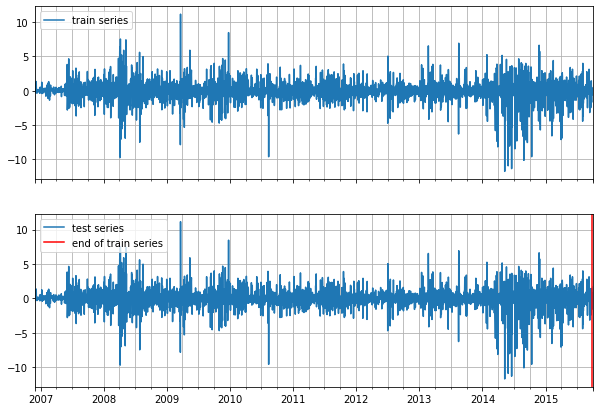

In [127]:
from gluonts.dataset.util import to_pandas
import matplotlib.pyplot as plt

test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

In [128]:
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.trainer import Trainer

INFO:root:Using CPU


In [168]:
estimator = SimpleFeedForwardEstimator(
    num_hidden_dimensions=[2],
    prediction_length=custom_ds_metadata["prediction_length"],
    context_length=custom_ds_metadata["num_steps"],
    freq=custom_ds_metadata["freq"],
    trainer=Trainer(ctx="cpu",
                    epochs=5,
                    learning_rate=1e-10,
                    num_batches_per_epoch=1
                   )
)


In [169]:
predictor = estimator.train(train_ds)

INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 1e-10
100%|██████████| 1/1 [00:00<00:00, 11.93it/s, avg_epoch_loss=6.15]
INFO:root:Epoch[0] Elapsed time 0.086 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=6.151338
INFO:root:Epoch[1] Learning rate is 1e-10
100%|██████████| 1/1 [00:00<00:00, 62.30it/s, avg_epoch_loss=4.97]
INFO:root:Epoch[1] Elapsed time 0.019 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=4.968611
INFO:root:Epoch[2] Learning rate is 1e-10
100%|██████████| 1/1 [00:00<00:00, 27.45it/s, avg_epoch_loss=7.17]
INFO:root:Epoch[2] Elapsed time 0.040 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.165109
INFO:root:Epoch[3] Learning rate is 1e-10
  0%|          | 0/1 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 1/1 [00:00<00:00, 30.71it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[3] Elapsed time 0.035 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.552984
INFO:root:Epoch[4] Learning rate is 1e-10
100%|██████████| 1/1 [00:00<00:00, 50.35it/s, avg_epoch_loss=7.91]
INFO:root:Epoch[4] Elapsed time 0.041 seconds
INFO:root:Epoch[4] Evaluation metric 'epoch_loss'=7.908207
INFO:root:Loading parameters from best epoch (1)
INFO:root:Final loss: 4.968611240386963 (occurred at epoch 1)
INFO:root:End model training


In [170]:
from gluonts.evaluation.backtest import make_evaluation_predictions

In [171]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

In [172]:
forecasts = list(forecast_it)
tss = list(ts_it)

In [174]:
ts_entry = tss[0]
np.array(ts_entry[:5]).reshape(-1,)

array([-0.01006993,  0.2887139 , -0.00359216, -0.17164895, -0.12738441],
      dtype=float32)

In [175]:
dataset_test_entry = next(iter(test_ds))
dataset_test_entry['target'][:5]

array([-0.01006993,  0.2887139 , -0.00359216, -0.17164895, -0.12738441],
      dtype=float32)

In [177]:
# first entry of the forecast list
forecast_entry = forecasts[0]
forecast_entry

gluonts.model.forecast.SampleForecast(freq="1D", info=None, item_id=None, samples=numpy.array([[0.6122493743896484, -4.167239665985107, -0.04457396641373634, 1.106551170349121, -0.8011446595191956, -0.04735901206731796, 3.5479726791381836], [1.6781991720199585, -4.8271565437316895, -2.541624069213867, 1.6564743518829346, 0.18856678903102875, 0.28845611214637756, 3.616079330444336], [0.7727991938591003, -1.560744047164917, -0.5304620862007141, 1.4455347061157227, -0.6203256845474243, 2.104306936264038, 3.574719190597534], [-0.4886147677898407, -4.020352840423584, -3.0346827507019043, 1.273681879043579, 1.3134114742279053, 0.39139100909233093, 3.557532787322998], [3.2779550552368164, -3.6373138427734375, -0.9116600751876831, 1.4846644401550293, -2.1834914684295654, -0.8614535331726074, 3.629730463027954], [1.2456377744674683, -4.439658164978027, -6.626098155975342, 1.5979238748550415, -0.02853619121015072, 1.1213908195495605, 3.790647029876709], [1.8610399961471558, -3.764014482498169, -

In [178]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 150
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

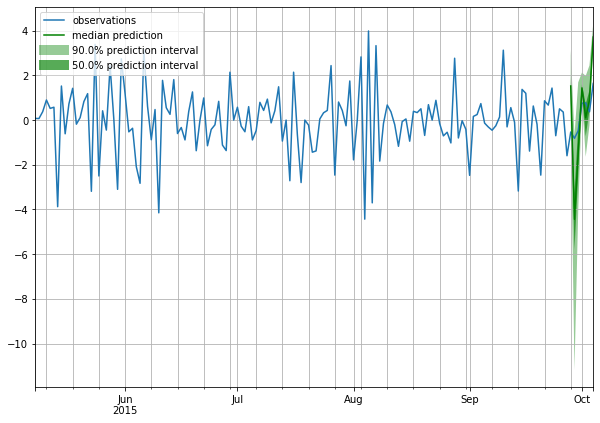

In [179]:
plot_prob_forecasts(ts_entry, forecast_entry)

In [181]:
from gluonts.evaluation import Evaluator

evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))

Running evaluation: 100%|██████████| 35/35 [00:00<00:00, 114.34it/s]


In [183]:
import json 
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 0.8560446933824188,
    "abs_error": 173.12968349456787,
    "abs_target_sum": 32.79070860147476,
    "abs_target_mean": 0.13383962694479493,
    "seasonal_error": 0.4784601185670017,
    "MASE": 1.5614500649759848,
    "sMAPE": 1.7360414854524102,
    "MSIS": 28.82654647840765,
    "QuantileLoss[0.1]": 139.9250310540199,
    "Coverage[0.1]": 0.3551020408163265,
    "QuantileLoss[0.5]": 173.1296839080751,
    "Coverage[0.5]": 0.4571428571428571,
    "QuantileLoss[0.9]": 55.58706783112138,
    "Coverage[0.9]": 0.726530612244898,
    "RMSE": 0.9252268334751316,
    "NRMSE": 6.912951377672037,
    "ND": 5.279839652101369,
    "wQuantileLoss[0.1]": 4.267215837102306,
    "wQuantileLoss[0.5]": 5.279839664711869,
    "wQuantileLoss[0.9]": 1.695207886682307,
    "mean_wQuantileLoss": 3.7474211294988273,
    "MAE_Coverage": 0.15714285714285714
}


# Deepar estimator

In [185]:
from gluonts.model.deepar import DeepAREstimator

INFO:root:Using CPU


In [196]:
estimator = SimpleFeedForwardEstimator(
    prediction_length=custom_ds_metadata["prediction_length"],
    context_length=100,
    freq=custom_ds_metadata["freq"]
)

In [197]:
predictor = estimator.train(train_ds)

INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/50 [00:00<?, ?it/s]INFO:root:Number of parameters in SimpleFeedForwardTrainingNetwork: 15643


learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 50/50 [00:00<00:00, 129.58it/s, avg_epoch_loss=0.514]
INFO:root:Epoch[0] Elapsed time 0.389 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=0.513848
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 159.09it/s, avg_epoch_loss=0.4]
INFO:root:Epoch[1] Elapsed time 0.317 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=0.399889
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 164.29it/s, avg_epoch_loss=0.379]
INFO:root:Epoch[2] Elapsed time 0.307 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=0.378529
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 149.32it/s, avg_epoch_loss=0.361]
INFO:root:Epoch[3] Elapsed time 0.338 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=0.361130
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 134.13it/s, avg_epoch_loss=0.36]
INFO:root:Epoch[4] Elapsed time 0.375 seconds
INFO:root:Epoc

100%|██████████| 50/50 [00:00<00:00, 135.56it/s, avg_epoch_loss=0.332]
INFO:root:Epoch[37] Elapsed time 0.371 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=0.332180
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 159.27it/s, avg_epoch_loss=0.293]
INFO:root:Epoch[38] Elapsed time 0.317 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=0.293044
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 114.99it/s, avg_epoch_loss=0.274]
INFO:root:Epoch[39] Elapsed time 0.440 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=0.274164
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 147.73it/s, avg_epoch_loss=0.334]
INFO:root:Epoch[40] Elapsed time 0.340 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=0.333582
INFO:root:Epoch[41] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 147.40it/s, avg_epoch_loss=0.32]
INFO:root:Epoch[41] Elapsed time 0.343 sec

In [188]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

forecasts = list(forecast_it)
tss = list(ts_it)

In [189]:
ts_entry = tss[0]
np.array(ts_entry[:5]).reshape(-1,)

array([-0.01006993,  0.2887139 , -0.00359216, -0.17164895, -0.12738441],
      dtype=float32)

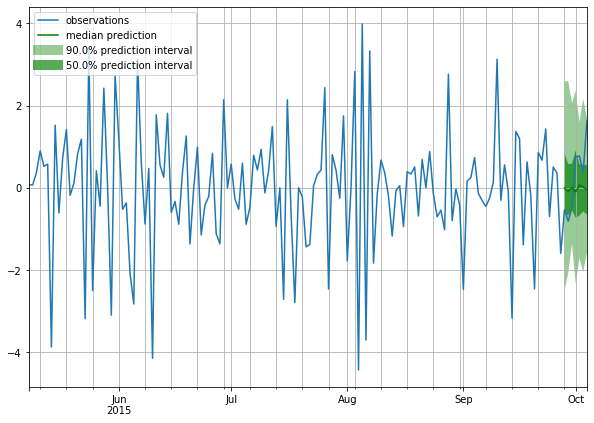

In [198]:
forecast_entry = forecasts[0]

plot_prob_forecasts(ts_entry, forecast_entry)

In [199]:
from gluonts.evaluation import Evaluator

evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))

Running evaluation: 100%|██████████| 35/35 [00:00<00:00, 141.05it/s]


In [200]:
import json 
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 0.058407400016273786,
    "abs_error": 33.42280754446983,
    "abs_target_sum": 32.79070860147476,
    "abs_target_mean": 0.13383962694479493,
    "seasonal_error": 0.4784601185670017,
    "MASE": 0.2557110528367295,
    "sMAPE": 1.7022576954465543,
    "MSIS": 2.3520451353765544,
    "QuantileLoss[0.1]": 17.230849052220588,
    "Coverage[0.1]": 0.12653061224489798,
    "QuantileLoss[0.5]": 33.422807386377826,
    "Coverage[0.5]": 0.5183673469387754,
    "QuantileLoss[0.9]": 14.433821030706167,
    "Coverage[0.9]": 0.9306122448979591,
    "RMSE": 0.241676229729516,
    "NRMSE": 1.8057150579865306,
    "ND": 1.0192767698520135,
    "wQuantileLoss[0.1]": 0.5254796186821541,
    "wQuantileLoss[0.5]": 1.0192767650307697,
    "wQuantileLoss[0.9]": 0.44018021098992066,
    "mean_wQuantileLoss": 0.6616455315676147,
    "MAE_Coverage": 0.025170068027210824
}
